In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and pipeline utilities
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Machine Learning Models

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier, ExtraTreesClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, Perceptron, SGDClassifier
)
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Model Evaluation and Selection
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)



In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


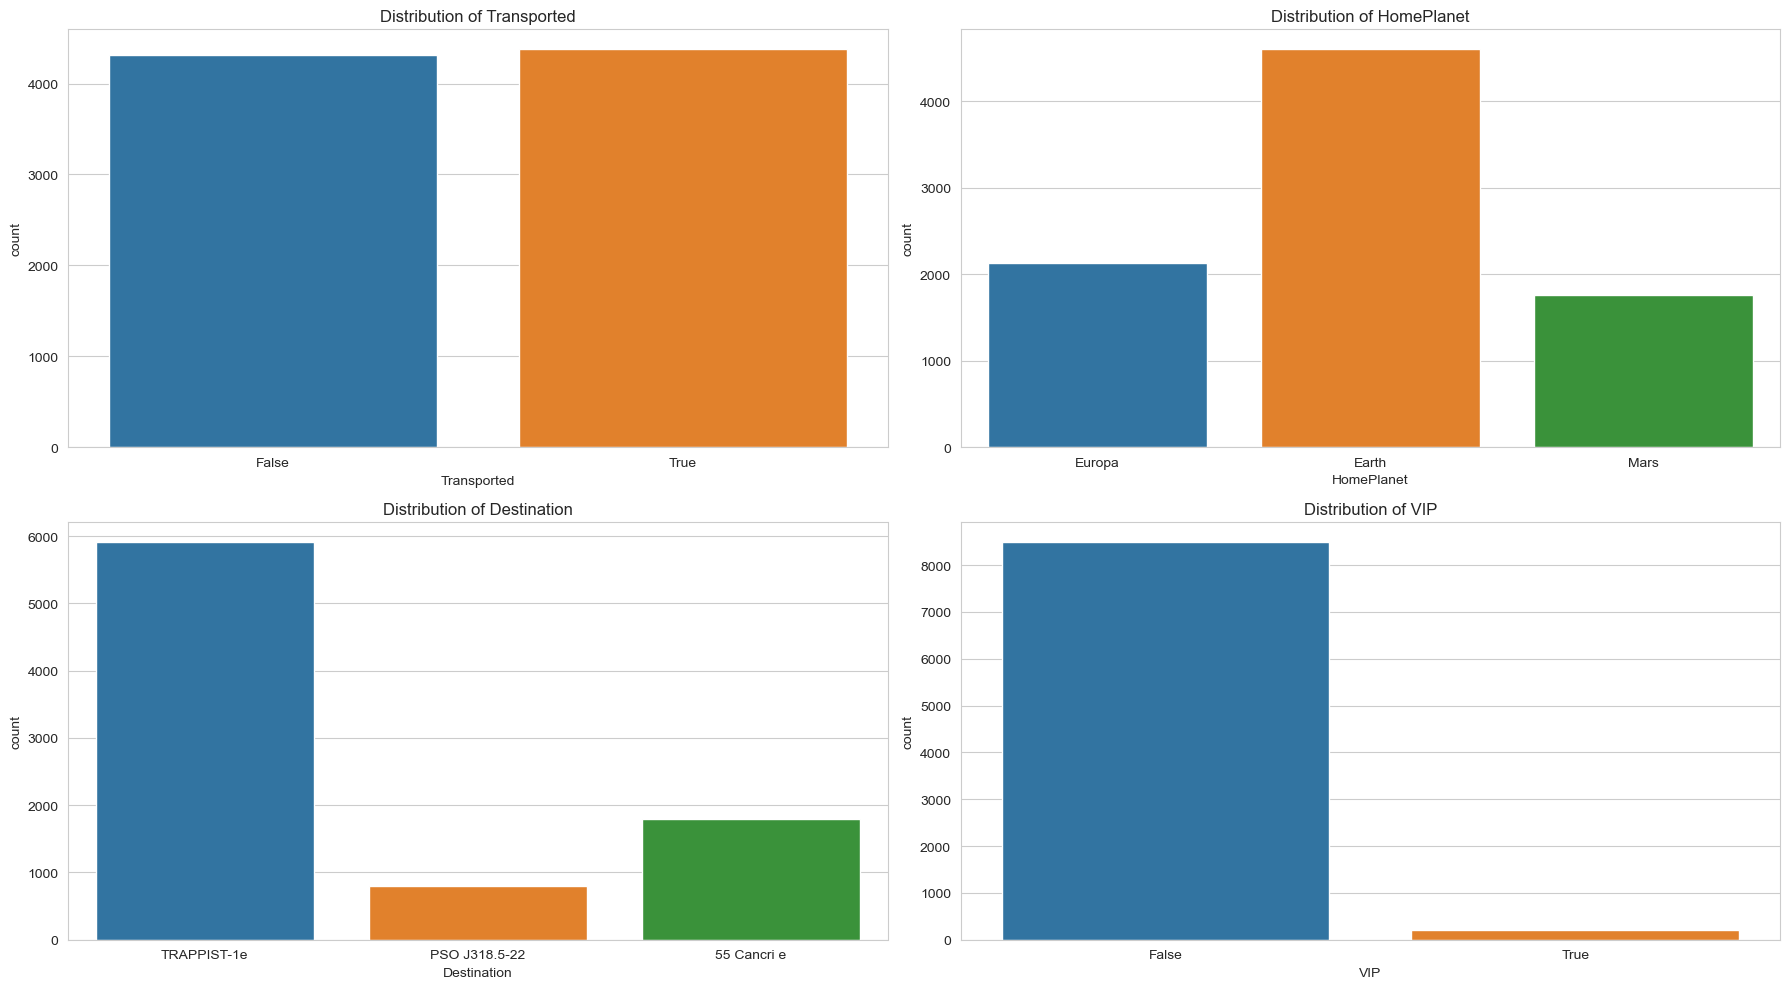

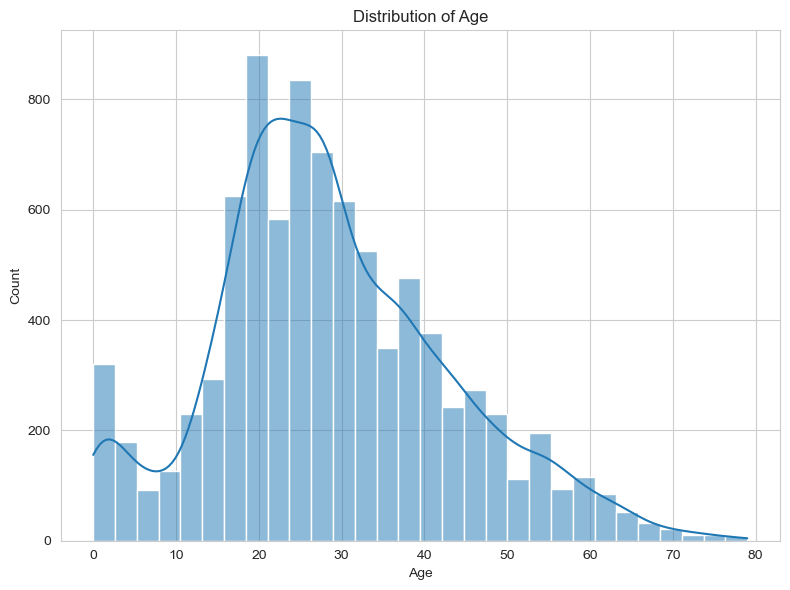

HomePlanet         201
CryoSleep            0
Destination        182
Age                  0
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Transported          0
TravelGroupSize      0
Deck               199
Num                199
Side               199
dtype: int64


In [3]:
# Set up the aesthetics for the plots
sns.set_style("whitegrid")

# Create a figure with 2x2 subplots
fig, ax = plt.subplots(2, 2, figsize=(18, 10))

# Plot 1: Distribution of the target variable "Transported"
sns.countplot(data=df, x="Transported", ax=ax[0, 0])
ax[0, 0].set_title("Distribution of Transported")

# Plot 2: Distribution of the "HomePlanet" feature
sns.countplot(data=df, x="HomePlanet", ax=ax[0, 1])
ax[0, 1].set_title("Distribution of HomePlanet")

# Plot 3: Distribution of the "Destination" feature
sns.countplot(data=df, x="Destination", ax=ax[1, 0])
ax[1, 0].set_title("Distribution of Destination")

# Plot 4: Distribution of the "VIP" feature
sns.countplot(data=df, x="VIP", ax=ax[1, 1])
ax[1, 1].set_title("Distribution of VIP")

plt.tight_layout()
plt.show()

# Create another figure for the distribution of "Age" as it uses a different plot type
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=df, x="Age", bins=30, kde=True, ax=ax)
ax.set_title("Distribution of Age")
plt.tight_layout()
plt.show()

# Check for missing values in the dataset
missing_values = df.isnull().sum()
print(missing_values)

In [6]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

## Preprocessing function

In [10]:
def preprocessing(df):

    def calculate_group_size(passenger_id, df):
        # Extract the prefix from the 'PassengerId'
        prefix = passenger_id.split('_')[0]
        
        # Count the occurrences of the same prefix in the entire DataFrame
        group_size = len(df[df['PassengerId'].str.startswith(prefix)])
        
        return group_size

    # Apply the function to create the 'TravelGroupSize' column
    df['TravelGroupSize'] = df.apply(lambda row: calculate_group_size(row['PassengerId'], df), axis=1)

    # Filling missing values for HomePlanet
    df['HomePlanet'] = df['HomePlanet'].fillna('Missing')

    # Filling missing values for CryoSleep
    df['CryoSleep'] = df['CryoSleep'].fillna('Missing')

    # Filling missing values for Cabin
    df['Cabin'] = df['Cabin'].fillna('Missing')
    
    # Cabin split
    mask = df['Cabin'] != "Missing"

    # Split 'Cabin' into 'Deck', 'Num', and 'Side' columns
    split_values = df['Cabin'].str.split('/', expand=True)

    # Assign the split values to 'Deck' and 'Side' for non-"Unknown" rows
    df.loc[mask, 'Deck'] = split_values[0]
    df.loc[mask, 'Num'] = split_values[1]
    df.loc[mask, 'Side'] = split_values[2]

    # Fill missing
    df['Deck'] = df['Deck'].fillna("Missing")
    df['Num'] = df['Num'].fillna("Missing")
    df['Side'] = df['Side'].fillna("Missing")

    # Filling missing values for Destination
    df['Destination'] = df['Destination'].fillna('Missing')

    # Filling missing values for Age
    df['Age'] = df['Age'].fillna(df['Age'].mean())

    # Filling missing values for VIP
    df['VIP'] = df['VIP'].fillna("Missing")

    # Filling missing values for amenities
    df[['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']] = df[['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']].fillna(0)
    
    # Filling missing values with NaN
    cols_with_missing = df.columns[df.isin(['Missing']).any()].tolist()
    for col in cols_with_missing:
        df[col] = df[col].replace('Missing', np.nan)



    # Less important features
    df = df.drop(columns=['Name', 'PassengerId', 'Cabin'])

    return df

In [11]:
pp_train_df = preprocessing(train_df)
pp_test_df = preprocessing(test_df)
pp_train_df.to_csv('../data/train_preprocessed.csv', index=False)
pp_test_df.to_csv('../data/test_preprocessed.csv', index=False)

In [12]:
df = pd.read_csv('../data/train_preprocessed.csv')

# Separate features and target variable
X = df.drop(columns=["Transported"])
y = df["Transported"]

# Define numeric and categorical features
numeric_features = ['Age','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService','Num','TravelGroupSize']
categorical_features = ['HomePlanet', 'Deck', 'Side', 'Destination', 'VIP', 'CryoSleep']

# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply transformers to the appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])


# Define a list of classifiers and their respective hyperparameter grids
classifiers = {
    
    #  'SVM': (SVC(), {
    #      'classifier__C': [8],
    #      'classifier__kernel': ['rbf'],
    #      'classifier__gamma': [0.009],  #list(np.arange(0.008,0.012,0.001))
    #      'classifier__probability': [True],
    #      'classifier__class_weight': ['balanced'],
    #      'classifier__shrinking': [True],
    #      'classifier__random_state': [42],}),

    # 'Logistic Regression': (LogisticRegression(), { #Best Logistic Regression Accuracy: 0.79580
    #     'classifier__C': [.93],
    #     'classifier__penalty': ['l1'],       
    #     'classifier__solver': ['liblinear'],
    #     'classifier__random_state': [42],
    # }),

    # 'Random Forest': (RandomForestClassifier(), {
    #     'n_estimators': [100, 200, 300],  # Number of trees in the forest
    #     'criterion': ['gini', 'entropy'],  # Splitting criterion
    #     'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    #     'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    #     'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    #     'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider
    #     'bootstrap': [True, False],  # Whether to use bootstrap samples
    #     'class_weight': [None, 'balanced'],  # Class weights
    #     'random_state': [42],  # Random seed for reproducibility
    #     'n_jobs': [-1],  # Number of CPU cores to use for parallel processing
    # }),

    # 'XGBoost': (XGBClassifier(), {
    #     'classifier__learning_rate': [0.01, 0.1, 0.2],      # Learning rate
    #     'classifier__n_estimators': [50, 100, 200],          # Number of boosting rounds
    #     'classifier__max_depth': [3, 4, 5],                 # Maximum depth of trees
    #     'classifier__min_child_weight': [1, 2, 4],          # Minimum sum of instance weight (hessian) needed in a child
    #     'classifier__subsample': [0.8, 0.9, 1.0],           # Fraction of samples used for fitting the trees
    #     'classifier__colsample_bytree': [0.8, 0.9, 1.0],    # Fraction of features used for fitting the trees
    #     'classifier__reg_alpha': [0.0, 0.1, 0.5],           # L1 regularization term
    #     'classifier__reg_lambda': [0.0, 0.1, 0.5],          # L2 regularization term
    #     'classifier__random_state': [42],
    # }),

    # 'LightGBM': (LGBMClassifier(), {
    #     'classifier__learning_rate': [0.01, 0.1, 0.2],      # Learning rate
    #     'classifier__n_estimators': [50, 100, 200],          # Number of boosting rounds
    #     'classifier__max_depth': [3, 4, 5],                 # Maximum depth of trees
    #     'classifier__min_child_samples': [10, 20, 30],      # Minimum number of samples per leaf
    #     'classifier__subsample': [0.8, 0.9, 1.0],           # Fraction of samples used for fitting the trees
    #     'classifier__colsample_bytree': [0.8, 0.9, 1.0],    # Fraction of features used for fitting the trees
    #     'classifier__reg_alpha': [0.0, 0.1, 0.5],           # L1 regularization term
    #     'classifier__reg_lambda': [0.0, 0.1, 0.5],          # L2 regularization term
    #     'classifier__random_state': [42],
    # }),


    # 'K-Nearest Neighbors': (KNeighborsClassifier(), {
    #     'classifier__n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    #     'classifier__weights': ['uniform', 'distance'],  # Weight function
    #     'classifier__p': [1, 2],  # Distance metric (1 for Manhattan, 2 for Euclidean)
    # }),

    # 'MLP Neural Network': (MLPClassifier(), {
    #     'classifier__max_iter': [1000],  # Maximum number of iterations
    #     'classifier__hidden_layer_sizes': [(200,),],  # Vary the number of neurons in a single hidden layef
    #     'classifier__activation': ['tanh'],  # Activation function
    #     'classifier__solver': ['adam'],  # Solver for weight optimization
    #     'classifier__alpha': [0.12],  # L2 penalty (regularization term)
    #     'classifier__learning_rate': ['constant'],  # Learning rate schedule
    #     'classifier__random_state': [42],
    # }),

    #  'Naive Bayes': (GaussianNB(), {}),  # No hyperparameters to tune for Gaussian Naive Bayes

    # 'Decision Tree': (DecisionTreeClassifier(), {
    #     'classifier__criterion': ['gini', 'entropy'],  # Criterion for splitting
    #     'classifier__max_depth': [None, 10, 20],      # Maximum depth of the tree
    #     'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    #     'classifier__min_samples_leaf': [1, 2, 4],    # Minimum samples required at leaf nodes
    #     'classifier__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    #     'classifier__random_state': [42],
    # }),



    # 'AdaBoost': (AdaBoostClassifier(), {
    #     'classifier__n_estimators': [280],  # Number of weak learners (decision trees)
    #     'classifier__learning_rate': [.2],  
    #     'classifier__random_state': [42],
    # }),

    # 'Bagging': (BaggingClassifier(), {
    #     'classifier__n_estimators': [10, 20, 30],  # Number of base estimators (decision trees)
    #     'classifier__max_samples': [0.7, 0.8, 0.9, 1.0],  # Fraction of samples used for training each base estimator
    #     'classifier__max_features': [0.7, 0.8, 0.9, 1.0],  # Fraction of features used for training each base estimator
    #     'classifier__random_state': [42],
    # }),

    # 'Extra Trees': (ExtraTreesClassifier(), {
    #     'classifier__n_estimators': [50, 100, 200],  # Number of decision trees in the forest
    #     'classifier__criterion': ['gini', 'entropy'],  # Criterion for splitting
    #     'classifier__max_depth': [None, 10, 20],      # Maximum depth of the trees
    #     'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    #     'classifier__min_samples_leaf': [1, 2, 4],    # Minimum samples required at leaf nodes
    #     'classifier__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    #     'classifier__random_state': [42],
    # }),


    # 'Ridge Classifier': (RidgeClassifier(), {
    #     'classifier__alpha': [0.1, 1.0, 10.0],  # Regularization strength
    #     'classifier__random_state': [42],
    # }),

    # 'Passive Aggressive Classifier': (PassiveAggressiveClassifier(), {
    #     'classifier__C': [0.01, 0.1, 1.0],  # Regularization parameter
    #     'classifier__random_state': [42],
    # }),

    # 'Perceptron': (Perceptron(), {
    #     'classifier__alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    #     'classifier__penalty': ['l1', 'l2'],          # Regularization penalty
    #     'classifier__random_state': [42],
    # }),

    # 'SGD Classifier': (SGDClassifier(), {
    #     'classifier__alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    #     'classifier__penalty': ['l1', 'l2', 'elasticnet'],  # Regularization penalty
    #     'classifier__loss': ['hinge', 'log', 'modified_huber'],  # Loss function
    #     'classifier__random_state': [42],
    # }),
    
    # 'Voting Classifier': (VotingClassifier(estimators=[
    #     ('lr', LogisticRegression(random_state=42)),
    #     ('rf', RandomForestClassifier(random_state=42)),
    #     ('xgb', XGBClassifier(random_state=42))
    # ], voting='soft'), {}),

    # 'Stacking Classifier': (StackingClassifier(estimators=[
    #     ('lr', LogisticRegression(random_state=42)),
    #     ('rf', RandomForestClassifier(random_state=42)),
    #     ('xgb', XGBClassifier(random_state=42))
    # ], final_estimator=LogisticRegression()), {})
}

# Create a dictionary to store the best models
best_models = {}
classifier_accuracies = {}

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Iterate through the classifiers and perform GridSearchCV
for clf_name, (clf, param_grid) in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', clf)])
    
    stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
    

    grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_kfold, n_jobs=-1,scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_models[clf_name] = grid_search.best_estimator_
    best_accuracy = grid_search.best_score_
    classifier_accuracies[clf_name] = best_accuracy
    print(f'Best {clf_name} Model: {grid_search.best_params_}')
    print(f'Best {clf_name} Accuracy: {grid_search.best_score_:.5f}')
  


Best MLP Neural Network Model: {'classifier__activation': 'tanh', 'classifier__alpha': 0.12, 'classifier__hidden_layer_sizes': (200,), 'classifier__learning_rate': 'constant', 'classifier__max_iter': 1000, 'classifier__random_state': 42, 'classifier__solver': 'adam'}
Best MLP Neural Network Accuracy: 0.81089


In [52]:
from sklearn.calibration import CalibratedClassifierCV
final_model = best_models['MLP Neural Network']

# Calibrate the model
calibrated_clf = CalibratedClassifierCV(final_model, method='sigmoid', cv='prefit')
calibrated_clf.fit(X_val, y_val)

# Predict using the calibrated model
X_test = pd.read_csv('../data/test_preprocessed.csv')
original_test_data = pd.read_csv('../data/test.csv')

passenger_id_df = original_test_data[['PassengerId']]
y_pred_probs = calibrated_clf.predict_proba(X_test)[:, 1]
y_pred = ["True" if prob > 0.5 else "False" for prob in y_pred_probs]

predicted_df = pd.DataFrame({'Transported': y_pred})
submission_df = pd.concat([passenger_id_df, predicted_df], axis=1)
submission_df.to_csv('../data/submission.csv', index=False)

In [18]:
final_model=best_models['SVM']
final_model.fit(X,y)


X_test = pd.read_csv('../data/test_preprocessed.csv')


# Load the original test data
original_test_data = pd.read_csv('../data/test.csv')

# Extract the "PassengerId" column
passenger_id_df = original_test_data[['PassengerId']]


y_pred = final_model.predict(X_test)

# Create a DataFrame for the predicted "Transported" values
predicted_df = pd.DataFrame({'Transported': y_pred})

# Concatenate the "PassengerId" and predicted "Transported" DataFrames
submission_df = pd.concat([passenger_id_df, predicted_df], axis=1)

# Save the concatenated DataFrame to a CSV file
submission_df.to_csv('../data/submission_svm.csv', index=False)

In [45]:
df=pd.read_csv('../data/submission.csv')
df.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
